In [1]:
import os,shutil
import h5py
import matplotlib.pyplot as plt

# Helpers
from SimEx.Utilities.Units import meter, electronvolt, joule, radian

# PMI
from SimEx.Calculators.XMDYNDemoPhotonMatterInteractor import XMDYNDemoPhotonMatterInteractor

# Simple Beam Parameters
from SimEx.Parameters.PhotonBeamParameters import PhotonBeamParameters

# Diffraction
from SimEx.Parameters.DetectorGeometry import DetectorGeometry, DetectorPanel
from SimEx.Parameters.SingFELPhotonDiffractorParameters import SingFELPhotonDiffractorParameters
from SimEx.Calculators.SingFELPhotonDiffractor import SingFELPhotonDiffractor

# Analysis
from SimEx.Analysis.XFELPhotonAnalysis import XFELPhotonAnalysis
from SimEx.Analysis.DiffractionAnalysis import DiffractionAnalysis, plotResolutionRings, azimuthalIntegration, totalNPattern,photonStatistics

import matplotlib.colors as colors

initializing ocelot...


In [2]:
def cleanUp(out_path):
    dirs_to_remove=[out_path]
    files_to_remove=[out_path+'.h5']

    for d in dirs_to_remove:
        if os.path.isdir(d):
            shutil.rmtree(d)
    for f in files_to_remove:
        if os.path.isfile(f):
            os.remove(f)

## SPI diffraction pattern from chaperonin

In [3]:
# Beam setup
beam = PhotonBeamParameters(
    photon_energy=4.96e3 * electronvolt,
    beam_diameter_fwhm=1.0e-6 * meter,
    pulse_energy=1.0e-3 * joule * 3900,
)

# Detector setup
p0 = DetectorPanel(ranges={
    'fast_scan_min': 0,
    'fast_scan_max': 99,
    'slow_scan_min': 0,
    'slow_scan_max': 99
},
                   pixel_size=440e-6 * meter,
                   photon_response=1.0,
                   distance_from_interaction_plane=0.13 * meter,
                   corners={
                       'x': -49.5,
                       'y': -49.5
                   },
                   fast_scan_xyz='1.0x',
                   slow_scan_xyz='1.0y')

detector_geometry = DetectorGeometry(panels=[p0])

In [4]:
diffraction_parameters = SingFELPhotonDiffractorParameters(
                                               uniform_rotation=True,
                                               slice_interval=1,
                                               number_of_slices=1,
                                               number_of_diffraction_patterns=40,
                                               detector_geometry=detector_geometry,
                                               beam_parameters = beam)

In [5]:
diffr_path = "diffr"

In [6]:
cleanUp(diffr_path)

In [7]:
diffractor = SingFELPhotonDiffractor(parameters=diffraction_parameters,
                                     input_path='3IYF.pdb',
                                     output_path=diffr_path)

Notice: corners setting in the DetectorGeometry takes no effects in pysingFEL calculations.But it will still be exported by detector_geometry.serialize.


In [8]:
from timeit import default_timer as timer
start = timer()

status = diffractor.backengine()

end = timer()
print(end - start,'s') # Time in seconds
if (status == 0):
    print ("Successful!")
else:
    print ("Error code:",status)

38.22917408309877 s
Successful!


In [9]:
# Link the .h5 output generated from mpirun together
diffractor.saveH5()

## Diffraction pattern analysis

Total number of patterns in the dataset:  40
Number of patterns to analyze:  1


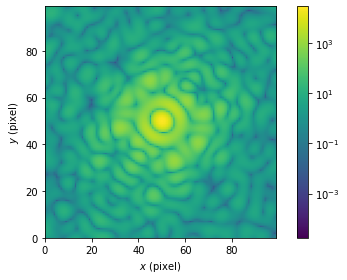

In [10]:
analyzer = DiffractionAnalysis(input_path=diffr_path+'.h5',
                               pattern_indices=1,
                               poissonize=False
                              )
print ('Total number of patterns in the dataset: ',totalNPattern(diffr_path+'.h5'))
print ('Number of patterns to analyze: ',analyzer.npattern)
fig, ax = analyzer.plotPattern(logscale=True)

### Show resolution rings

Number of patterns to analyze:  40


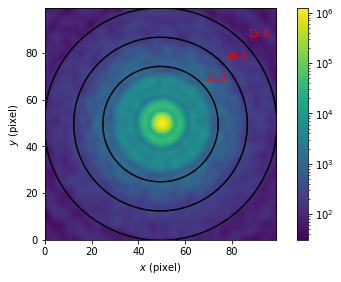

In [11]:
analyzer = DiffractionAnalysis(input_path=diffr_path+'.h5',
                               pattern_indices='all',
                               poissonize=False
                              )
print ('Number of patterns to analyze: ',analyzer.npattern)
analyzer.plotPattern(logscale=True)
plotResolutionRings(analyzer.parameters,rings= (30,20,15), half=False)

### Plot radial projection as a function of q  

  File "/opt/SimEx-master/Sources/python/SimEx/Analysis/DiffractionAnalysis.py", line 528, in azimuthalIntegration
    wavelength=lmd*1e-9)


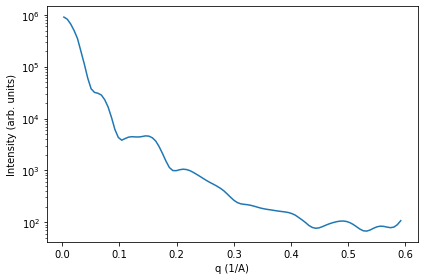

In [12]:
analyzer.plotRadialProjection(logscale=True,offset=0,unit="q_A^-1")

### Photon statistics

*************************
Photon number statistics per pattern
avg = 1.01874e+06
std = 3.55084e+04
Photon number statistics per pixel
avg_mean_pixel = 1.01874e+02
avg_max_pixel = 3.03735e+04
avg_min_pixel = 1.89176e-04
*************************


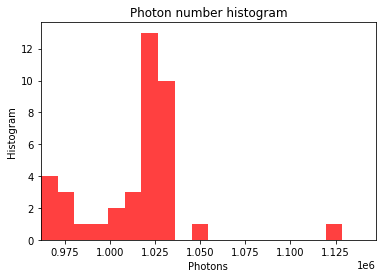

In [13]:
analyzer.statistics()

### Read patterns into numpy array

In [14]:
diffr_data = analyzer.numpyPattern()

In [15]:
print (diffr_data.shape)

(40, 100, 100)


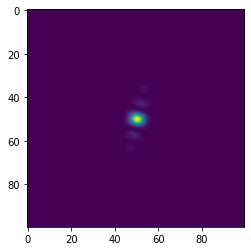

In [16]:
plt.imshow(diffr_data[0])

This project has received funding from the European Union's Horizon 2020 research and innovation programme under grant agreement No. 823852.